In [ ]:
#Install split-folders package
%pip install split-folders

In [ ]:
#perform all imports for the lab
from zipfile import ZipFile
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import splitfolders
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import numpy as np
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import os

#set use_cuda to true for GPU use
use_cuda = True

#Extract the data folders from the zip file
#In order to do this, the zip file must be saved
#to the files section of Colab
file_name = "/content/Lab3 Dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

In [ ]:
#Use the split-folders package to split the data.
#I chose the following split: 80% training, 10% validation, 10% test
#I chose this split because based on my research, it is a pretty
#standard split. It gives the vast majority of the data to the
#training set, while leaving enough data for validation and a decent
#amount of completely unseen data for testing.

splitfolders.ratio("/content/Lab3_Gestures_Summer", output="split_data",
    seed=999, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)


Copying files: 2219 files [00:00, 4941.22 files/s]


<ipython-input-6-821c90f847de>:20: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  plt.imshow(image.T)


0


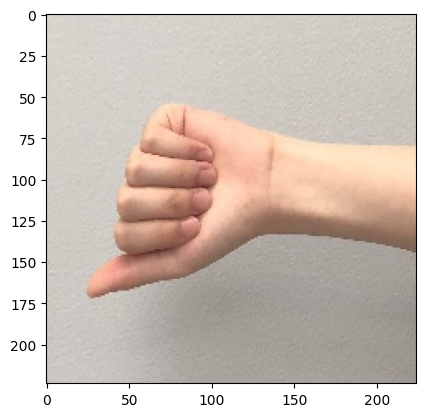

In [ ]:
#Define the transformations that I will apply to the data
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((224,224))])

#Create train, validation, and testing datasets
#Apply the transformations
train_data = ImageFolder("/content/split_data/train", transform)
val_data = ImageFolder("/content/split_data/val", transform)
test_data = ImageFolder("/content/split_data/test", transform)

#Load all of the datasets into their respective loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=10,
                                         shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10,
                                          shuffle=True)
image, label = next(iter(train_data))
plt.imshow(image.T)
print(label)

In [ ]:
#Get model name for checkpointing
def get_model_name(name, batch_size, learning_rate, epoch):
   path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size,
                                                  learning_rate, epoch)
   return path

In [ ]:
#Find the accuracy of the model
def get_accuracy(model, data_loader):
    #initialize counters
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        #Enable GPU if available
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    #Return accuracy
    return correct / total

In [ ]:
#plot accuracy
def plot_training_curve(path, num_epochs, train_acc, val_acc):
    plt.title("Training Curve")
    n = len(num_epochs) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train(model, train_loader, val_loader, batch_size=64, num_epochs=15,
          learn_rate=0.001):
    #Set seed
    torch.manual_seed(1700)

    #Set loss function and optimizer
    #I chose to use cross entropy loss for the loss function because
    #we have been taught that this is generally the best performing
    #loss function for multiclass classification problems.
    #I chose to use Adam as the optimizer because according to my
    #research, Adam generally provides very good results without
    #significant fine tuning.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    #populate accuracy arrays with zeroes
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)

    #initialize iteration counter
    n = 0
    for epoch in range(num_epochs):
        for images, labels in iter(train_loader):
            #Enable GPU if available
            if use_cuda and torch.cuda.is_available():
              images = images.cuda()
              labels = labels.cuda()

            #perform forwards pass
            out = model(images)
            #Compute loss using Cross Entropy loss function
            loss = criterion(out, labels)
            #backward pass to calculate and update parameters.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #increment iteration counter
            n += 1

        # track training and validation accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)

        #output accuracy
        print(("Epoch: {} | Training acc: {} |" + "Validation acc: {}"
        ).format(epoch, train_acc[epoch], val_acc[epoch]))

        #checkpoint model
        model_path = get_model_name(model.name, batch_size, learn_rate,
                                    epoch)
        torch.save(model.state_dict(), model_path)

    epochs = np.arange(1, num_epochs + 1)

    #plot training curve
    plot_training_curve(model_path, epochs, train_acc, val_acc)

Epoch: 0 | Training acc: 0.2 |Validation acc: 0.2
Epoch: 1 | Training acc: 0.2 |Validation acc: 0.2
Epoch: 2 | Training acc: 0.2 |Validation acc: 0.2
Epoch: 3 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 4 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 5 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 6 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 7 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 8 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 9 | Training acc: 0.3 |Validation acc: 0.3
Epoch: 10 | Training acc: 0.4 |Validation acc: 0.4
Epoch: 11 | Training acc: 0.4 |Validation acc: 0.4
Epoch: 12 | Training acc: 0.5 |Validation acc: 0.5
Epoch: 13 | Training acc: 0.8 |Validation acc: 0.8
Epoch: 14 | Training acc: 0.8 |Validation acc: 0.8
Epoch: 15 | Training acc: 0.9 |Validation acc: 0.9
Epoch: 16 | Training acc: 1.0 |Validation acc: 1.0
Epoch: 17 | Training acc: 0.8 |Validation acc: 0.8
Epoch: 18 | Training acc: 1.0 |Validation acc: 1.0
Epoch: 19 | Training acc: 1.0 |Validation

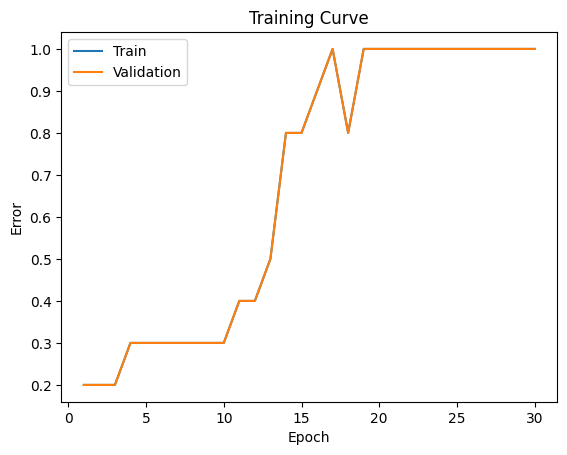

In [ ]:
model = CNN_ASLCLassifier()

#sample 10 random indices from the training data
indices = np.random.choice(len(train_data), size=10, replace=False)
#create an overfit dataset as a subset of the training dataset
overfit_data = Subset(train_data, indices)
#Load the overfit dataset
overfit_loader = DataLoader(overfit_data, batch_size=2, shuffle=True)

#Enable GPU if available.
if use_cuda and torch.cuda.is_available():
  model.cuda()

train(model, overfit_loader, overfit_loader, num_epochs=30, batch_size=27,
      learn_rate=0.001)
#Please note that since I passed the overfit_loader for both the
#parameters train_loader and val_loader, the training and validation
#accuracy seen here will be identical because they are the same thing

Epoch: 0 | Training acc: 0.45711060948081267 |Validation acc: 0.4930875576036866
Epoch: 1 | Training acc: 0.6715575620767494 |Validation acc: 0.6682027649769585
Epoch: 2 | Training acc: 0.6930022573363431 |Validation acc: 0.6866359447004609
Epoch: 3 | Training acc: 0.7454853273137697 |Validation acc: 0.695852534562212
Epoch: 4 | Training acc: 0.7940180586907449 |Validation acc: 0.7327188940092166
Epoch: 5 | Training acc: 0.8329571106094809 |Validation acc: 0.7603686635944701
Epoch: 6 | Training acc: 0.8673814898419865 |Validation acc: 0.7511520737327189
Epoch: 7 | Training acc: 0.8188487584650113 |Validation acc: 0.7004608294930875
Epoch: 8 | Training acc: 0.9215575620767494 |Validation acc: 0.7465437788018433
Epoch: 9 | Training acc: 0.9430022573363431 |Validation acc: 0.7695852534562212
Epoch: 10 | Training acc: 0.9548532731376975 |Validation acc: 0.8064516129032258
Epoch: 11 | Training acc: 0.9644469525959368 |Validation acc: 0.815668202764977
Epoch: 12 | Training acc: 0.98081264108

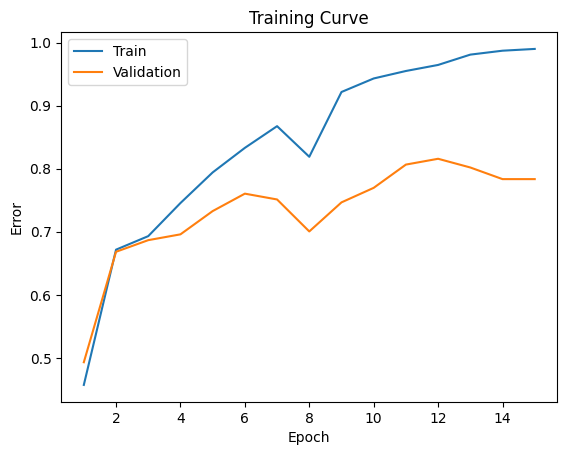

In [ ]:
#I start out by using the default values of my model that I set
#during training batch_size=64, num_epochs=15, learn_rate=0.001

model1 = CNN_ASLCLassifier()
if use_cuda and torch.cuda.is_available():
  model1.cuda()

train(model1, train_loader, val_loader)

Epoch: 0 | Training acc: 0.11117381489841986 |Validation acc: 0.11059907834101383
Epoch: 1 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 2 | Training acc: 0.11060948081264109 |Validation acc: 0.11059907834101383
Epoch: 3 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 4 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 5 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 6 | Training acc: 0.11286681715575621 |Validation acc: 0.1152073732718894
Epoch: 7 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 8 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 9 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 10 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 11 | Training acc: 0.11455981941309255 |Validation acc: 0.1152073732718894
Epoch: 12 | Training acc

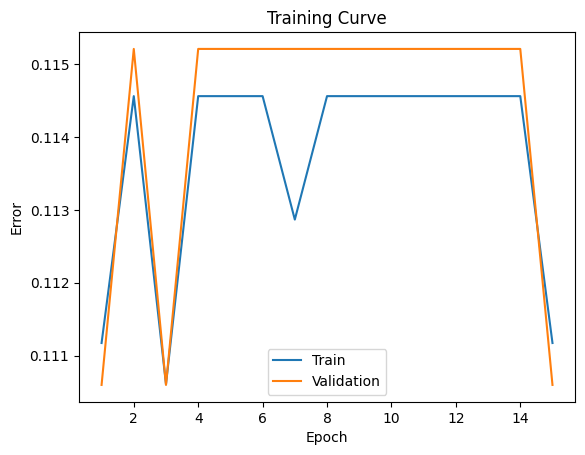

In [ ]:
#Now I'm going to increase the learning rate to 0.01
#batch_size=64, num_epochs=15, learn_rate=0.01

model2 = CNN_ASLCLassifier()
if use_cuda and torch.cuda.is_available():
  model2.cuda()

train(model2, train_loader, val_loader, learn_rate = 0.01)

Epoch: 0 | Training acc: 0.33690744920993226 |Validation acc: 0.391705069124424
Epoch: 1 | Training acc: 0.6461625282167043 |Validation acc: 0.6267281105990783
Epoch: 2 | Training acc: 0.7172686230248307 |Validation acc: 0.6866359447004609
Epoch: 3 | Training acc: 0.791196388261851 |Validation acc: 0.7235023041474654
Epoch: 4 | Training acc: 0.8510158013544018 |Validation acc: 0.7465437788018433
Epoch: 5 | Training acc: 0.8781038374717833 |Validation acc: 0.7004608294930875
Epoch: 6 | Training acc: 0.948645598194131 |Validation acc: 0.7603686635944701
Epoch: 7 | Training acc: 0.9475169300225733 |Validation acc: 0.7557603686635944
Epoch: 8 | Training acc: 0.9644469525959368 |Validation acc: 0.7741935483870968
Epoch: 9 | Training acc: 0.9830699774266366 |Validation acc: 0.7235023041474654
Epoch: 10 | Training acc: 0.9272009029345373 |Validation acc: 0.7188940092165899
Epoch: 11 | Training acc: 0.9870203160270881 |Validation acc: 0.7465437788018433
Epoch: 12 | Training acc: 0.998306997742

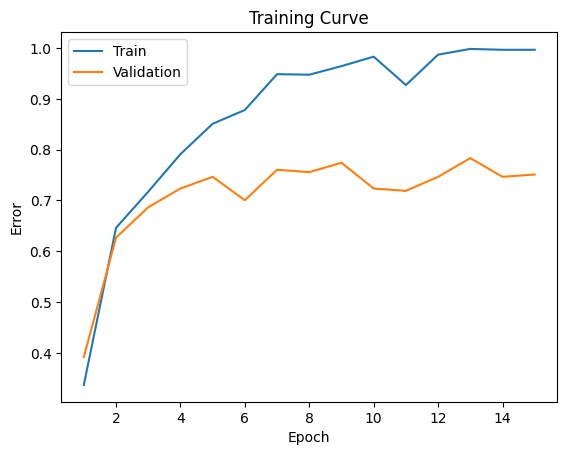

In [ ]:
#Increasing the learning rate to 0.01 gave terrible results,
#so I'm going to set it back to 0.001, and try increasing
#the batch size to 128
##batch_size=128, num_epochs=15, learn_rate=0.001

model3 = CNN_ASLCLassifier()
if use_cuda and torch.cuda.is_available():
  model3.cuda()

train(model3, train_loader, val_loader, batch_size = 128)

Epoch: 0 | Training acc: 0.5869074492099323 |Validation acc: 0.5622119815668203
Epoch: 1 | Training acc: 0.6439051918735892 |Validation acc: 0.6036866359447005
Epoch: 2 | Training acc: 0.718961625282167 |Validation acc: 0.6589861751152074
Epoch: 3 | Training acc: 0.7866817155756207 |Validation acc: 0.7235023041474654
Epoch: 4 | Training acc: 0.8572234762979684 |Validation acc: 0.7419354838709677
Epoch: 5 | Training acc: 0.8944695259593679 |Validation acc: 0.695852534562212
Epoch: 6 | Training acc: 0.9130925507900677 |Validation acc: 0.7050691244239631
Epoch: 7 | Training acc: 0.9356659142212189 |Validation acc: 0.7188940092165899
Epoch: 8 | Training acc: 0.9288939051918735 |Validation acc: 0.7050691244239631
Epoch: 9 | Training acc: 0.9892776523702032 |Validation acc: 0.728110599078341
Epoch: 10 | Training acc: 0.9915349887133182 |Validation acc: 0.7603686635944701
Epoch: 11 | Training acc: 0.9554176072234764 |Validation acc: 0.7188940092165899
Epoch: 12 | Training acc: 0.9791196388261

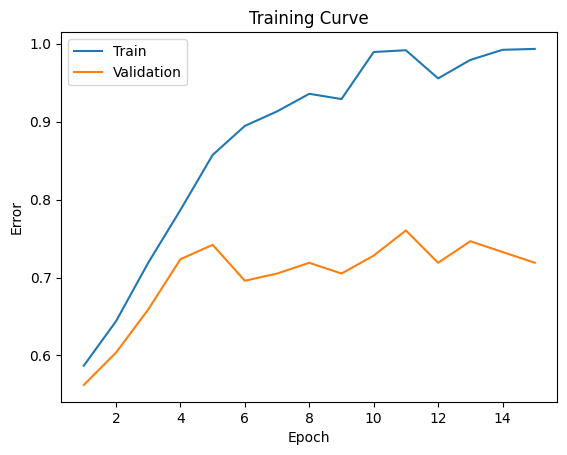

In [ ]:
#Increasing the batch size to 128 slightly worsened the accuracy,
#so I will go back to a batch size of 64. I'm now going to change the
#output channel sizes of the three convolutional layers to 32, 64, and
#128. (While also changing the respective input channels to match.)
#The channels would be:
#self.conv1 = nn.Conv2d(3, 32, 7)
#self.conv2 = nn.Conv2d(32, 64, 5)
#self.conv3 = nn.Conv2d(64, 128, 3)
#self.fc1 = nn.Linear(128*25*25, 36)
#self.fc2 = nn.Linear(36, 9)

model4 = CNN_ASLCLassifier()
if use_cuda and torch.cuda.is_available():
  model4.cuda()

train(model4, train_loader, val_loader)

In [ ]:
path = get_model_name(model1.name, batch_size=64, learning_rate=0.001,
                      epoch=11)
state = torch.load(path)
model1.load_state_dict(state)

criterion = nn.CrossEntropyLoss()
test_acc = get_accuracy(model1, test_loader)
print(test_acc)

0.7695652173913043


In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 174MB/s]


In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features(img)

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Reinitialize loaders with batch size of 1
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                           num_workers=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1,
                                           num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                           num_workers=1, shuffle=True)

#Function to save the features to folders in Google Drive
def save_features(loader, main_path):
  #Intialize counter
  num = 0
  #create array of classes
  classes = ['A','B','C','D','E','F','G','H', 'I']

  for image, label in loader:
    #Compute convolutional features
    features = alexnet.features(image)
    #convert AlexNet feature tensor into numpy array and back
    features = torch.from_numpy(features.detach().numpy())

    path = main_path + '/' + str(classes[label])
    if not os.path.isdir(path):
      os.mkdir(path)
    torch.save(features.squeeze(0), path + '/' + str(num) + '.tensor')
    num += 1
    #torch.save(features.squeeze(0), path + '/'  + '.tensor')
    #all_features = []
    #all_labels = []

save_features(train_loader, '/content/gdrive/My Drive/Lab3/train_feats')
save_features(val_loader, '/content/gdrive/My Drive/Lab3/val_feats')
save_features(test_loader, '/content/gdrive/My Drive/Lab3/test_feats')


Link to Google Drive folder:

https://drive.google.com/drive/folders/1BaKr1tw8vhrBAM1xwTf4EDJr-h57szRs?usp=share_link

In [ ]:
#load the features
train_data = torchvision.datasets.DatasetFolder(
    '/content/gdrive/My Drive/Lab3/train_feats',
    loader=torch.load, extensions=('.tensor'))
val_data = torchvision.datasets.DatasetFolder(
    '/content/gdrive/My Drive/Lab3/val_feats',
    loader=torch.load, extensions=('.tensor'))
test_data = torchvision.datasets.DatasetFolder(
    '/content/gdrive/My Drive/Lab3/test_feats',
    loader=torch.load, extensions=('.tensor'))

train_feat_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=32,
                                                shuffle=True)
val_feat_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=32,
                                                shuffle=True)
test_feat_loader = torch.utils.data.DataLoader(test_data,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
# features = ... load precomputed alexnet.features(img) ...
output = model(features)
prob = F.softmax(output)

In [ ]:
#I used 1 convoluntional layer, 2 fully connected layers, and
#1 pooling layer, because I now wanted to see if going down to
#1 convolutional layer would have a noticeable impact on this task.
#I once again used ReLU as the activation function for the same
#reasons as before. I increased the number of out channels in the
#single convolutional layer to 128.

torch.manual_seed(1300)
from math import floor
class CNN_AlexNetCLassifier(nn.Module):
    def __init__(self, name = "CNN_AlexNetCLassifier"):
        super(CNN_AlexNetCLassifier, self).__init__()
        self.conv1 = nn.Conv2d(256, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*2*2, 32)
        self.fc2 = nn.Linear(32, 9)
        self.name = name

    def forward(self, features):
        x = self.pool(F.relu(self.conv1(features)))
        x = x.view(-1, 128*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

Epoch: 0 | Training acc: 0.7934537246049661 |Validation acc: 0.783410138248848
Epoch: 1 | Training acc: 0.9283295711060948 |Validation acc: 0.9170506912442397
Epoch: 2 | Training acc: 0.9435665914221218 |Validation acc: 0.9032258064516129
Epoch: 3 | Training acc: 0.945823927765237 |Validation acc: 0.9032258064516129
Epoch: 4 | Training acc: 0.9565462753950339 |Validation acc: 0.9216589861751152
Epoch: 5 | Training acc: 0.963882618510158 |Validation acc: 0.9308755760368663
Epoch: 6 | Training acc: 0.9661399548532731 |Validation acc: 0.9308755760368663
Epoch: 7 | Training acc: 0.9683972911963883 |Validation acc: 0.9354838709677419
Epoch: 8 | Training acc: 0.9706546275395034 |Validation acc: 0.9308755760368663
Epoch: 9 | Training acc: 0.9706546275395034 |Validation acc: 0.9400921658986175
Epoch: 10 | Training acc: 0.9723476297968398 |Validation acc: 0.9493087557603687
Epoch: 11 | Training acc: 0.9734762979683973 |Validation acc: 0.9354838709677419
Epoch: 12 | Training acc: 0.9751693002257

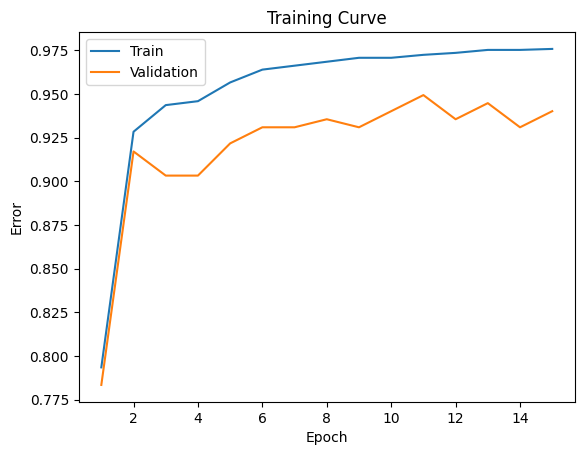

In [ ]:
Alex_model = CNN_AlexNetCLassifier()
if use_cuda and torch.cuda.is_available():
  Alex_model.cuda()

train(Alex_model , train_feat_loader, val_feat_loader, batch_size = 128,
      learn_rate = 0.001, num_epochs = 15)

In [ ]:
path = get_model_name(Alex_model.name, batch_size=128,
                      learning_rate=0.001, epoch=14)
state = torch.load(path)
Alex_model.load_state_dict(state)
test_acc = get_accuracy(Alex_model, test_feat_loader)
print(test_acc)
#As you can see below, the test accuracy is about 89%
#This is approximately 12% better than the test accuracy
#of my model ffrom 3(d) that didn't use transfer learning

0.8913043478260869
